In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement=Base.classes.measurement
station=Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session= Session(engine)

In [9]:
columns= inspect(engine).get_columns('measurement')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
columns= inspect(engine).get_columns('station')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date).first()

('2010-01-01')

In [15]:
# last_date
# pd.to_datetime(last_date)-dt.timedelta(days=365)

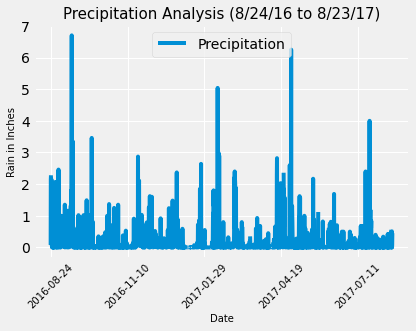

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date=session.query(measurement.date).order_by(measurement.date.desc()).first()
# Calculate the date one year from the last date in data set.
date_yearbefore=pd.to_datetime(last_date) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results=session.query(measurement.date,measurement.prcp).\
            filter(measurement.date > '2016-08-23').\
            order_by(measurement.date).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
# date = [dt.strptime((result[0]), "%y-%m-%d") for result in results]
date = [result[0] for result in results]
scores = [result[1] for result in results]
df=pd.DataFrame({"Date":date,"Precipitation":scores})
df=df.set_index('Date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.xlabel("Date",size=10)
plt.ylabel("Rain in Inches",size=10)
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)",size=15)
plt.xticks(rotation=45,fontsize = 10)
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.grid(b=True, which='minor', color='w', linewidth=0.5)

plt.legend(["Precipitation"],loc='best')
plt.show()



In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset
count=session.query(measurement.station).group_by(measurement.station).count()
print(f"The total number of stations in the dataset is {count}.")

The total number of stations in the dataset is 9.


In [23]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
a=session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).\
        order_by(func.count(measurement.station).desc()).all()

station = [x[0] for x in a]
count= [x[1] for x in a]
df=pd.DataFrame({"Station":station,"Count":count})
df

,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [28]:
ma_station=df['Station'][0]

In [61]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
Lowest=session.query(measurement.station,func.min(measurement.tobs)).\
        filter(measurement.station==ma_station).all()
       

Highest=session.query(measurement.station,func.max(measurement.tobs)).\
        filter(measurement.station==ma_station).all()

Average=session.query(measurement.station,func.avg(measurement.tobs)).\
        filter(measurement.station==ma_station).all()

print(f'The lowest temperature for station {ma_station} was {Lowest[0][1]}, highest temperature was {Highest[0][1]} and had an average temperature of {Average[0][1]}')

The lowest temperature for station USC00519281 was 54.0, highest temperature was 85.0 and had an average temperature of 71.66378066378067


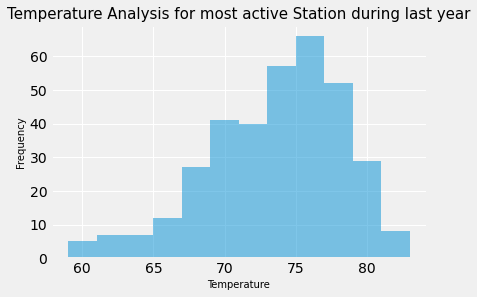

In [70]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query=session.query(measurement.station, measurement.tobs,measurement.date).\
        filter(measurement.station==ma_station).filter(measurement.date>'2016-08-23').all()

temp=[q[1] for q in query]

plt.hist(temp, bins=12, alpha=0.5)
plt.xlabel("Temperature",size=10)
plt.ylabel("Frequency",size=10)
plt.title("Temperature Analysis for most active Station during last year",size=15)

plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.grid(b=True, which='minor', color='w', linewidth=0.5)
plt.show()

# Close session

In [52]:
# Close Session
session.close()